## Loading Packages

In [6]:
import os

In [1]:
from deeplearning import *
from models import *
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import pickle
from preprocessing import *
import time
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from eval_inspect import *
import warnings

# warnings.filterwarnings("ignore")
torch.nn.Module.dump_patches = True

set_seed(42)

True

### Insuring that training is done on GPU if available

In [2]:
device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

Cuda installed! Running on GPU!


## Generating Data

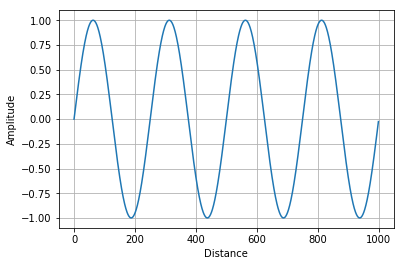

In [3]:
frequency = 4
sample_rate = 1000
x = np.arange(sample_rate)
y = np.sin(2 * np.pi * frequency * x / sample_rate)
plt.plot(x, y)
plt.xlabel('Distance')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

In [4]:
forecast_length = 5
data_X = y[:-forecast_length].reshape(len(y[:-forecast_length]), 1)
data_y = y[forecast_length:].reshape(len(y[:-forecast_length]), 1)

### Slicing Series into Windows

In [5]:
# The input size of each time series window
series_length = 100
data_X, data_y = slice_series(data_X, data_y, series_length, dataset_pct=1.0)

# [Number of series, time series length, number of features]
print("Data X shape", data_X.shape,
      "\nData y shape", data_y.shape)

Data X shape (895, 100, 1) 
Data y shape (895, 1)


### Hyperparameters

In [6]:
# Hyperparameters
learning_rate = 1e-2
momentum = 0.5
weight_decay = 0

# Batch Parameters
batch_size = 32

# Training Parameters
n_epochs = 10000
patience = 50
disp_freq= 10
fig_disp_freq= 10


# Model Parameters
num_features = data_X.shape[2]
hidden_dim = 8
dense_hidden = 32
num_layers = 1
output_dim = 1
dropout = 0.0

### Initialising the model

In [7]:
model = LSTM(num_features=num_features, 
             hidden_dim=hidden_dim,
             dense_hidden=dense_hidden,
             series_length = series_length,
             batch_size=batch_size,
             output_dim=output_dim, 
             num_layers=num_layers, 
             device=device,
             dropout=dropout)

model.to(device)

print("num_features %i \nhidden_dim %i\nseries_length %i \nbatch_size %i\noutput_dim %i \nnum_layers %i"
      % (num_features, hidden_dim, series_length, batch_size,output_dim, num_layers))

print('data_X ', data_X.shape, '\ndata_y', data_y.shape)

num_features 1 
hidden_dim 8
series_length 100 
batch_size 32
output_dim 1 
num_layers 1
data_X  (895, 100, 1) 
data_y (895, 1)


In [8]:
optimiser = torch.optim.Adam(model.parameters(), learning_rate)

learning = DeepLearning(model=model, 
                        data_X=data_X, 
                        data_y=data_y, 
                        n_epochs=100,
                        optimiser=optimiser,
                        batch_size=batch_size,
                        debug=False, 
                        disp_freq=disp_freq,
                        fig_disp_freq=fig_disp_freq, 
                        device=device,
                        patience=10)

# Splitting the data into the train, validation and test sets
learning.train_val_test()

### Training

Epoch: 0 Train: 0.00496 Val: 0.00512  Time: 0.928  Best Val: 0.00512


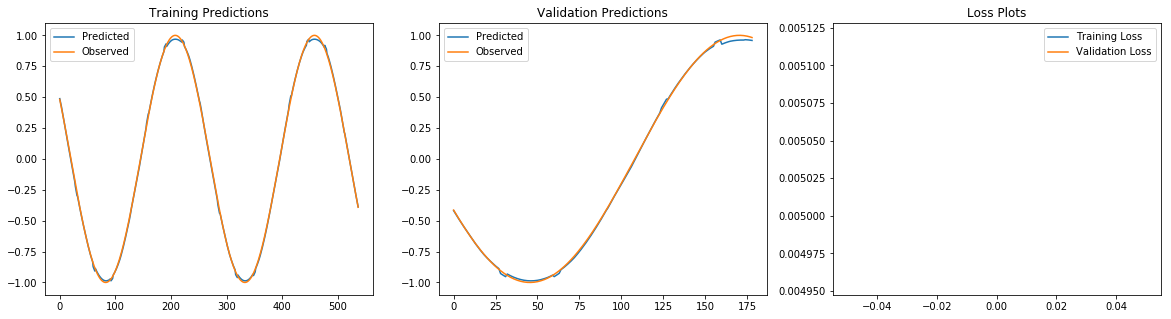

Early Stopping


In [12]:
# Allows for continious training by resetting the patience counter
learning.early.stop = False
learning.early.counter = 0
learning.training_wrapper()

### Evaluating the Test Data

In [16]:
learning.evaluate(learning.best_model, learning.test_loader)

0.008032108818352555

### Plotting

In [17]:
# Observed
train_true = learning.y_train.numpy()
val_true  = learning.y_val.numpy()
test_true  = learning.y_test.numpy()

# Predicted
train_pred = np.array(learning.train_predictions)
val_pred  = np.array(learning.val_predictions)
test_pred = np.array(learning.test_predictions)

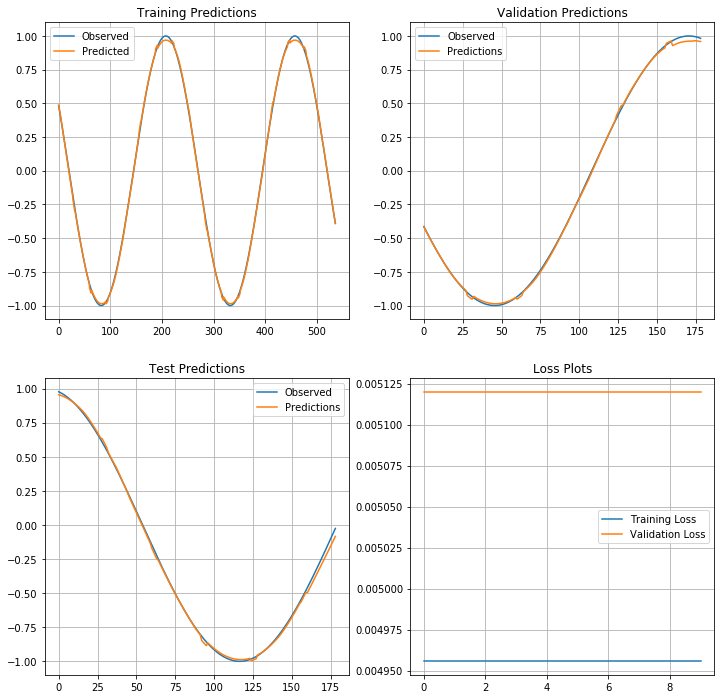

In [18]:
# Rescaling Example
fig, ax = plt.subplots(2, 2, figsize=(12, 12))

ax[0, 0].set_title("Training Predictions")
ax[0, 0].plot(train_true, label="Observed")
ax[0, 0].plot(train_pred, label="Predicted")
ax[0, 0].grid()
ax[0, 0].legend()

ax[0, 1].grid()
ax[0, 1].set_title("Validation Predictions")
ax[0, 1].plot(val_true, label="Observed")
ax[0, 1].plot(val_pred, label="Predictions")
ax[0, 1].legend()

ax[1, 0].grid()
ax[1, 0].set_title("Test Predictions")
ax[1, 0].plot(test_true, label="Observed")
ax[1, 0].plot(test_pred, label="Predictions")
ax[1, 0].legend()

ax[1, 1].grid()
ax[1, 1].set_title("Loss Plots")
ax[1, 1].plot(learning.logs['Training Loss'], label="Training Loss")
ax[1, 1].plot(learning.logs['Validation Loss'], label="Validation Loss")
ax[1, 1].legend()

epoch_reached = str(len(learning.logs['Training Loss']))
path = "Results/Plots/"
val_loss = learning.best_val_score

plt.show()

# Results

In [20]:
mse, mae, mda = evaluate(test_pred, test_true, log_ret=False)
print("Price Metrics: ", 
      mse, mae, mda)

Price Metrics:  0.0003409063183942753 0.013479591238015861 0.9775280898876404


### Naive Benchmark

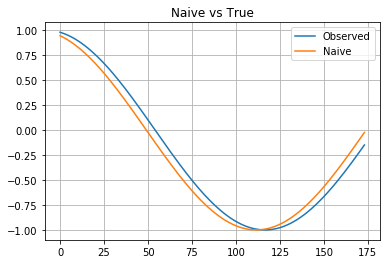

In [21]:
naive_pred = test_true[forecast_length:]

plt.plot(test_true[:-forecast_length] ,label="Observed")
plt.plot(naive_pred, label="Naive")
plt.title("Naive vs True")
plt.grid()
plt.legend()
plt.show()

### Metrics for benchmarks

In [30]:
mse_naive, mae_naive, mda_naive = evaluate(naive_pred, val_true[:-forecast_length], log_ret=False)
print("naive",
    mse_naive, mae_naive, mda_naive)

naive 0.00027619008 0.014623715 0.9774011299435028


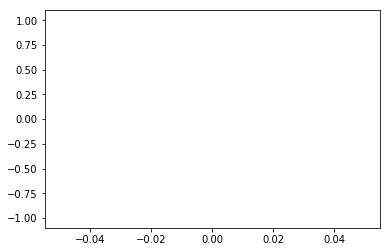

In [70]:
plt.plot(naive_pred.reshape(naive_pred.shape[1], naive_pred.shape[0]))

In [28]:
if mse_naive < mse:
    print("Naive Wins")
else:
    print("LSTM Wins")
    
if mae_naive < mae:
    print("Naive Wins")
else:
    print("LSTM Wins")
    
if mda_naive > mda:
    print("Naive Wins")
else:
    print("LSTM Wins")

Naive Wins
Naive Wins
Naive Wins
